In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 4) array of states into (N, M) indices in [0..31].
    
    Assumes:
      - The first three entries in the state are binary bits (0 or 1).
      - The last entry is an integer in [0..3].
      - If any of the four entries is NaN, the output is NaN for that row.
    
    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 4).
    
    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M). Valid rows are in the range [0..31].
        Rows with NaNs in the input remain NaN.
    """
    # Convert to numpy array (float allows NaN)
    all_state_array = np.array(all_state, dtype=float)

    # Validate shape: we want (N, M, 4)
    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 4:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 4).")
    
    # Create mask for rows that have ANY NaN
    nan_mask = np.isnan(all_state_array).any(axis=-1)  # shape: (N, M)

    # Prepare an output array filled with NaNs
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)  # shape: (N, M)

    # For valid rows (no NaNs), compute the index
    valid_mask = ~nan_mask

    # Weights for [a, b, c, x] => 16a + 8b + 4c + x
    # This yields a unique integer in [0..31].
    weights = np.array([16, 8, 4, 1], dtype=float)

    # Extract the valid data (2D: some number of rows by 4 columns)
    valid_data = all_state_array[valid_mask]  # shape: (?, 4)

    # Dot product for each row => scalar
    results = valid_data @ weights  # shape: (?)

    # Place results in the output
    indexed_states[valid_mask] = results

    return indexed_states



In [5]:
def index_to_state(index):
    """
    Converts an index (0-31) into a (4,) array where the first three
    entries are binary bits (0 or 1) and the last entry is in [0..3].

    The logic is:
      - The last entry is index % 4.
      - The first 3 bits come from index // 4, in [0..7].
    """
    if not (0 <= index < 32):
        raise ValueError(f"Index out of range: {index}. Expected 0-31.")

    # Last element: in [0..3]
    last_part = index % 4

    # The 3-bit portion is the integer in [0..7]
    binary_index = index // 4  # in [0..7]

    # Convert that binary_index into a 3-bit binary string, e.g. '011'
    binary_str = format(binary_index, '03b')

    # Create an array of the three bits
    bits = np.array([int(bit) for bit in binary_str], dtype=int)

    # Combine [first 3 bits, last_part]
    state = np.concatenate([bits, [last_part]])
    
    return state

In [6]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## Prepare the Data and the log (indicating of the data state)

In [7]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (85, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")

First array shape after conversion: (9002, 3)


In [8]:
# Find the minimum x-dimension across all arrays
min_x = min(arr.shape[0] for arr in all_cistrans)

print(f"Shortest x in all_cistrans: {min_x}")

Shortest x in all_cistrans: 3001


In [9]:
# Define paths
traj_path = '../PROJ12462traj'
log_path = '../log'

all_state = []

# Iterate over RUN and CLONE indices
for r in range(2, 3):  # Only r=2 for now
    for c in range(100):  # Iterate over c=0 to c=99
        csv_log = f"{log_path}/RUN{r}_CLONE{c}_log.csv"
        input_xtc_file = f"{traj_path}/r{r}c{c}_inte.xtc"

        # Corrected condition: Check if either file is missing
        if not os.path.exists(csv_log) or not os.path.exists(input_xtc_file):
            print(f"Missing file(s): {input_xtc_file if not os.path.exists(input_xtc_file) else ''}")
            print(f"Missing log file(s): {csv_log if not os.path.exists(csv_log) else ''}")
            continue

        # Load log and convert states
        df_log = pd.read_csv(csv_log, header=0)
        log = df_log.iloc[:, 0].values  # Convert to NumPy array
        all_state.append(log)

all_state

Missing file(s): ../PROJ12462traj/r2c8_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c32_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c46_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c48_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c49_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c57_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c59_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c77_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c79_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c87_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c91_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c93_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c95_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c96_inte.xtc
Missing log file(s): 
Missing

[array([0, 2, 1, ..., 2, 3, 2]),
 array([0, 1, 3, ..., 1, 2, 1]),
 array([0, 1, 3, ..., 0, 1, 1]),
 array([0, 2, 0, ..., 1, 1, 0]),
 array([0, 2, 1, ..., 2, 2, 2]),
 array([0, 2, 1, ..., 0, 1, 1]),
 array([0, 2, 1, ..., 3, 1, 2]),
 array([0, 3, 2, ..., 3, 2, 2]),
 array([0, 3, 0, ..., 3, 1, 2]),
 array([0, 2, 1, ..., 0, 1, 0]),
 array([0, 2, 0, ..., 3, 3, 0]),
 array([0, 2, 3, ..., 2, 3, 3]),
 array([0, 2, 2, ..., 0, 0, 1]),
 array([0, 3, 2, ..., 3, 0, 0]),
 array([0, 1, 3, ..., 0, 1, 1]),
 array([0, 2, 3, ..., 1, 0, 1]),
 array([0, 2, 1, ..., 3, 2, 3]),
 array([0, 2, 0, ..., 3, 2, 3]),
 array([0, 1, 3, ..., 3, 3, 3]),
 array([0, 1, 3, ..., 1, 0, 0]),
 array([0, 2, 1, ..., 1, 1, 1]),
 array([0, 3, 0, ..., 1, 1, 0]),
 array([0, 1, 1, ..., 3, 3, 1]),
 array([0, 1, 0, ..., 2, 1, 2]),
 array([0, 1, 1, ..., 3, 3, 2]),
 array([0, 2, 3, ..., 1, 2, 2]),
 array([0, 2, 0, ..., 1, 0, 1]),
 array([0, 2, 3, ..., 0, 2, 1]),
 array([0, 1, 1, ..., 0, 2, 1]),
 array([0, 2, 2, ..., 3, 2, 3]),
 array([0,

In [10]:
import numpy as np

unique_states = np.unique(all_state[9])
print(unique_states)


[0 1 2 3]


## Create a new data with 85, x, 4 (binary cis/trans state + lambda state)

In [11]:
# Assuming all_cistrans and all_state are lists of numpy arrays
new_all = []

for i in range(len(all_cistrans)):  # Loop over 85 trajectories
    x_len = all_cistrans[i].shape[0]  # Get the x dimension from all_cistrans

    # Trim all_state[i] to match the first x_len frames
    state_trimmed = all_state[i][:x_len]  # Ensure same length along x

    # Reshape state to (x, 1) if necessary
    state_trimmed = state_trimmed.reshape(-1, 1)  # Ensure shape (x, 1)

    # Concatenate along the last axis to get (x, 4)
    combined = np.concatenate((all_cistrans[i], state_trimmed), axis=1)

    # Append to new list
    new_all.append(combined)

new_all[4]

array([[1, 1, 1, 0],
       [1, 0, 0, 2],
       [1, 0, 1, 1],
       ...,
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 0]])

## Make a whole np traj.shape (85, 37002, 4) with nan, and convert the [1111] into individual 32 state

In [12]:
ntraj = len(new_all)
print(ntraj)

# Find the longest traj
maxlength = max( [ len(new_all[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 4) )

for i in range(ntraj):
    n = len(new_all[i])
    traj[i, 0:n, :] = new_all[i]

traj

85
maxlength 37002


array([[[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.

In [13]:
print('traj.shape', traj.shape)

traj_indexed = state_to_index_vectorized(traj)
print('traj_indexed.shape', traj_indexed.shape)
traj_indexed

traj.shape (85, 37002, 4)
traj_indexed.shape (85, 37002)


array([[28., 14., 13., ..., nan, nan, nan],
       [28., 29., 31., ..., nan, nan, nan],
       [28., 29., 31., ..., nan, nan, nan],
       ...,
       [28., 13., 15., ..., nan, nan, nan],
       [28., 12., 14., ..., nan, nan, nan],
       [28., 29., 31., ..., nan, nan, nan]])

## Calculating the cistrans population overtime

(37002,)


(0.0, 0.125)

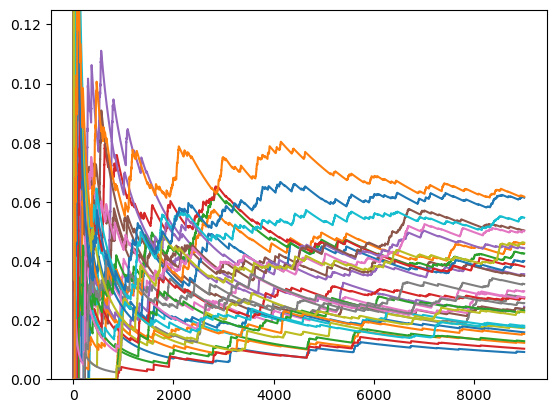

In [14]:
conform_num = 32

conform_population = calculate_conform_p(traj_indexed[0], conform_num)
print(traj_indexed[0].shape)
plt.plot(conform_population.T)  # Transpose: shape (37002, 32)
plt.ylim(0, 0.125)

In [16]:
## Load in the refer data 

df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime_8conforms.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='mean')
pivot_std = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='std')

# Convert to NumPy arrays
refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
refer_array.shape

(4, 8)

In [37]:
conform_num = 32
n_traj = traj_indexed.shape[0]
thermal_num = 4
conform_index = np.array([0, 4, 8, 12, 16, 20, 24, 28])

mean_all_res = []
rmsd_all_res = []

for thermal in range(thermal_num):
    # Store population results from each trajectory
    all_conform_populations = []

    for i in tqdm(range(n_traj), desc="Processing all trajectories"):
        single_traj = traj_indexed[i]
        # Skip NaNs inside calculate_conform_p
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    # Find the longest trajectory (in terms of time steps)
    maxlength = max([all_conform_populations[i].shape[1] for i in range(n_traj)])
    print('maxlength', maxlength)

    # Make an array to store all the conformational populations with padding
    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)

    for i in range(n_traj):
        conform_p = all_conform_populations[i]
        time_len = conform_p.shape[1]
        all_conform_p[i, :, :time_len] = conform_p
    #print(all_conform_p.shape)
  
    # Select conform for current thermal state and normalize
    conform_index_current = conform_index + thermal
    conform_p_current = all_conform_p[:, conform_index_current, :]
    total_p_current = np.nansum(conform_p_current, axis=1)
    normalized_conform_p = conform_p_current / total_p_current[:, None, :]

    #print(conform_p_current.shape) #(85, 8, 37002)
    #print(total_p_current.shape) #(85, 37002)

    # Refer population
    conform_refer = refer_array[thermal]
    #print(conform_refer.shape)

    # Calculate MEAN and RMSD
    mean_all_traj = np.nanmean(normalized_conform_p, axis=0)
    delta_trans_conform_p = np.abs(normalized_conform_p - conform_refer[None, :, None])
    rmsd_all_traj = np.sqrt(np.nanmean(delta_trans_conform_p**2, axis=0))
    
    #print(mean_all_traj.shape) #(8, 37002)
    #print(rmsd_all_traj.shape) #(8, 37002)

    mean_all_res.append(mean_all_traj)
    rmsd_all_res.append(rmsd_all_traj)

mean_all_res = np.stack(mean_all_res, axis=0)  # shape: (res_num, 4, maxlength)
rmsd_all_res = np.stack(rmsd_all_res, axis=0)  # same shape
rmsd_all_res.shape

Processing all trajectories: 100%|██████████| 85/85 [00:00<00:00, 166.58it/s]


maxlength 37002


Processing all trajectories: 100%|██████████| 85/85 [00:00<00:00, 169.90it/s]


maxlength 37002


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_23511/481182363.py:36: RuntimeWarning: invalid value encountered in divide
  normalized_conform_p = conform_p_current / total_p_current[:, None, :]
/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_23511/481182363.py:46: RuntimeWarning: Mean of empty slice
  mean_all_traj = np.nanmean(normalized_conform_p, axis=0)
/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_23511/481182363.py:48: RuntimeWarning: Mean of empty slice
  rmsd_all_traj = np.sqrt(np.nanmean(delta_trans_conform_p**2, axis=0))
Processing all trajectories: 100%|██████████| 85/85 [00:00<00:00, 169.83it/s]


maxlength 37002


Processing all trajectories: 100%|██████████| 85/85 [00:00<00:00, 130.30it/s]


maxlength 37002


(4, 8, 37002)

## Plot for each thermal

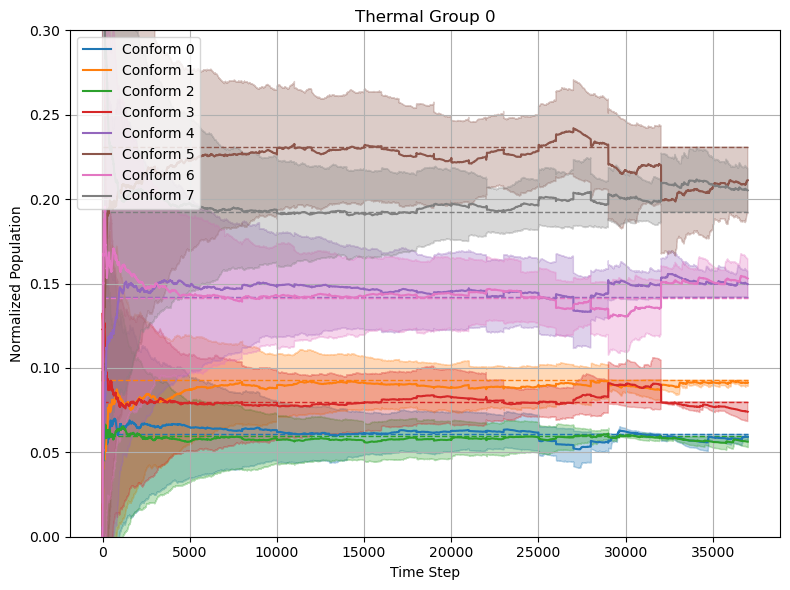

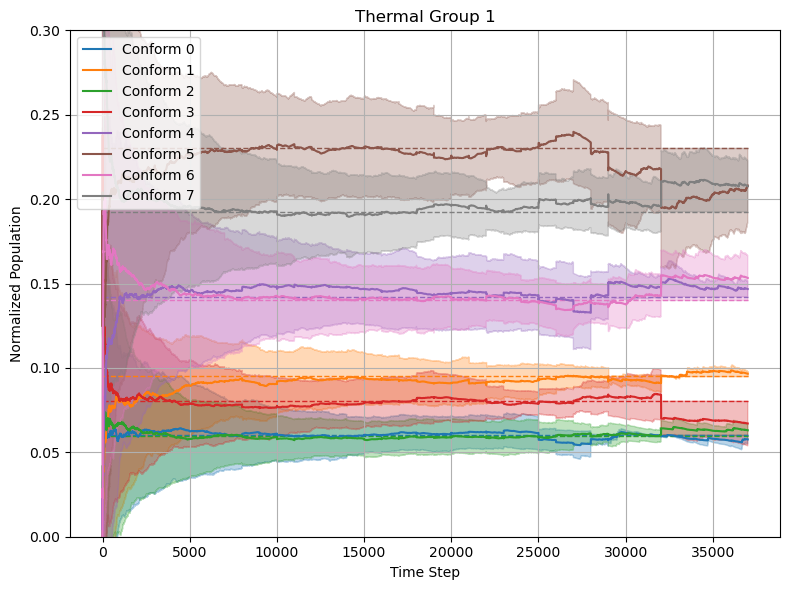

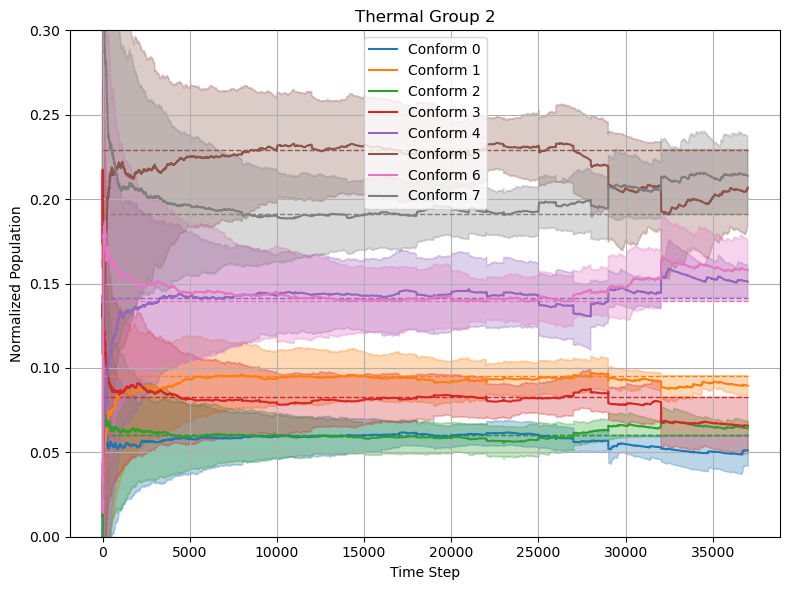

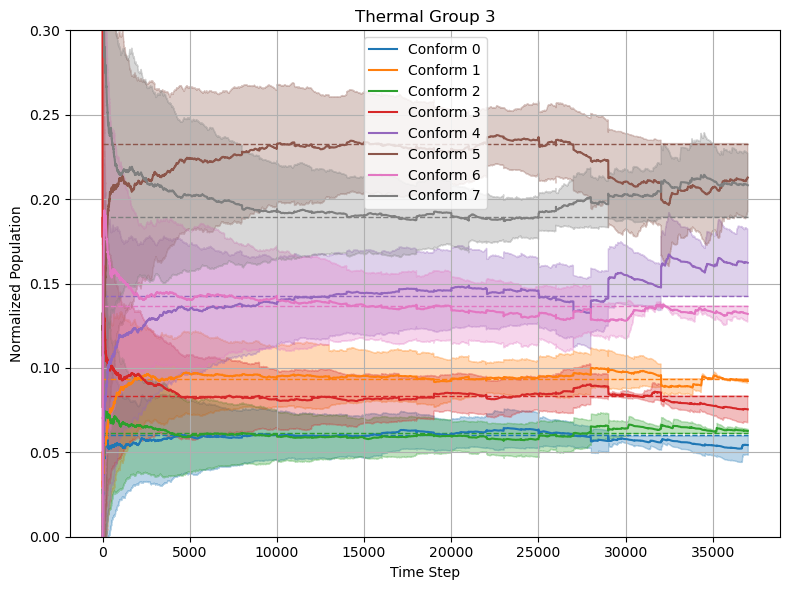

In [44]:
for thermal in range(thermal_num):
    time = np.arange(mean_all_res.shape[2])
    plt.figure(figsize=(8, 6))

    for conform in range(conform_num):
        mean = mean_all_res[thermal, conform, :]
        rmsd = rmsd_all_res[thermal, conform, :]
        ref = refer_array[thermal, conform]

        # Plot and capture the line object to get the color
        line, = plt.plot(time, mean, label=f'Conform {conform}')
        plt.fill_between(time, mean - rmsd, mean + rmsd, alpha=0.3, color=line.get_color())

        # Use the same color for the horizontal reference line
        plt.hlines(y=ref, xmin=time[0], xmax=time[-1],
                   colors=line.get_color(), linestyles='--', linewidth=1)

    plt.ylim(0, 0.3)
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Population")
    plt.title(f"Thermal Group {thermal}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


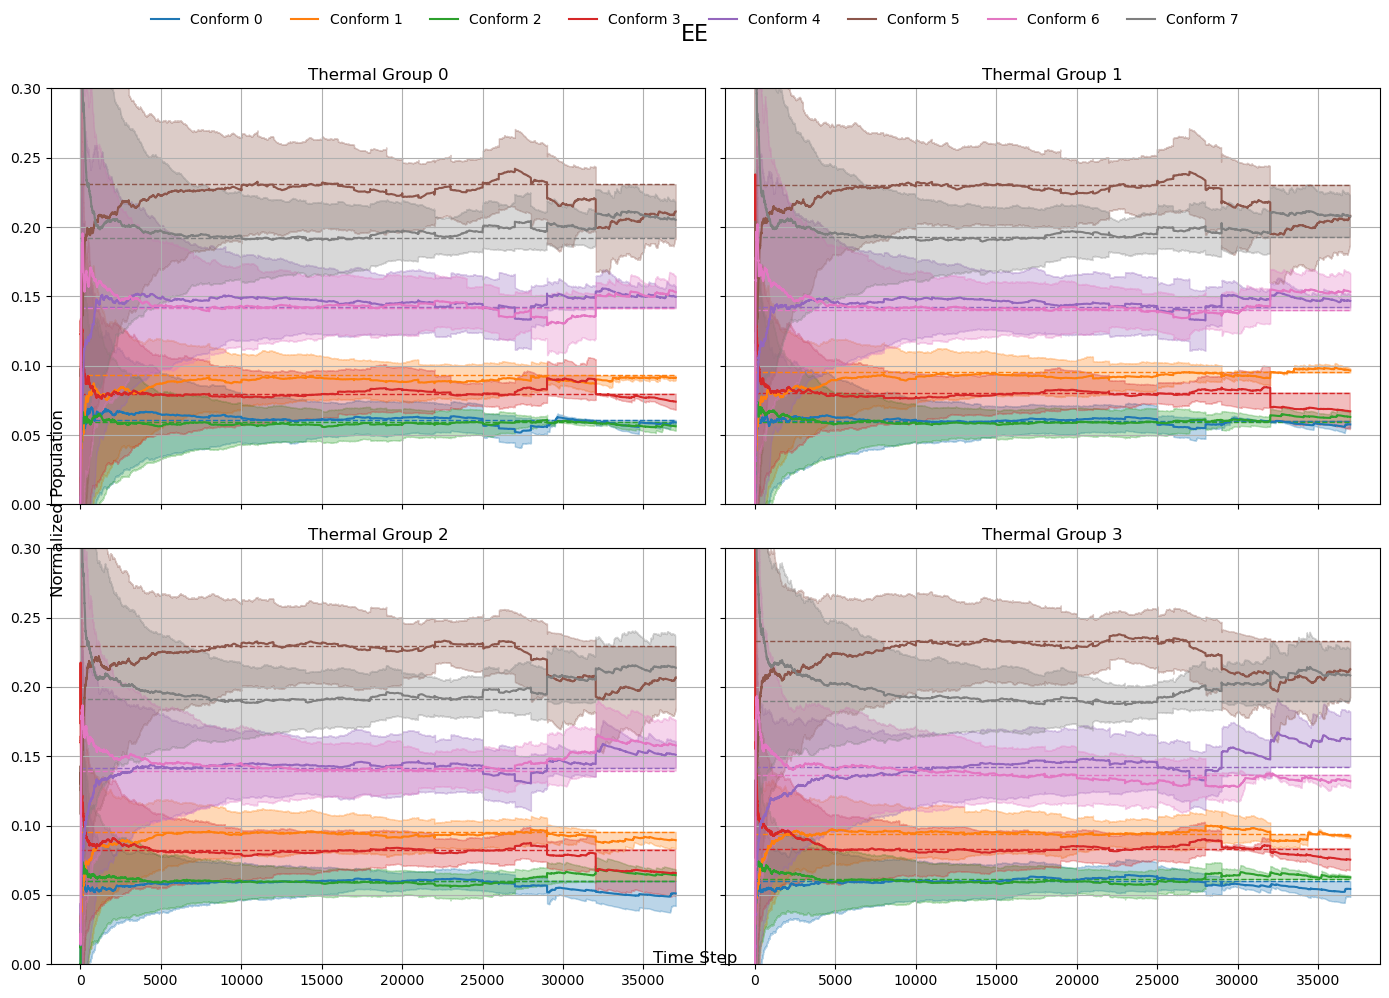

In [52]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
time = np.arange(mean_all_res.shape[2])

for thermal in range(thermal_num):
    row = thermal // 2
    col = thermal % 2
    ax = axs[row, col]

    for conform in range(conform_num):
        mean = mean_all_res[thermal, conform, :]
        rmsd = rmsd_all_res[thermal, conform, :]
        ref = refer_array[thermal, conform]

        # Plot mean and error fill
        line, = ax.plot(time, mean, label=f'Conform {conform}')
        ax.fill_between(time, mean - rmsd, mean + rmsd, alpha=0.3, color=line.get_color())
        ax.hlines(y=ref, xmin=time[0], xmax=time[-1],
                  colors=line.get_color(), linestyles='--', linewidth=1)

    ax.set_ylim(0, 0.3)
    ax.set_title(f"Thermal Group {thermal}")
    ax.grid(True)

# Add global labels
fig.text(0.5, 0.04, "Time Step", ha='center', fontsize=12)
fig.text(0.04, 0.5, "Normalized Population", va='center', rotation='vertical', fontsize=12)

# Add a single legend for all plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=conform_num, frameon=False)

fig.suptitle("EE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for shared legend
plt.show()


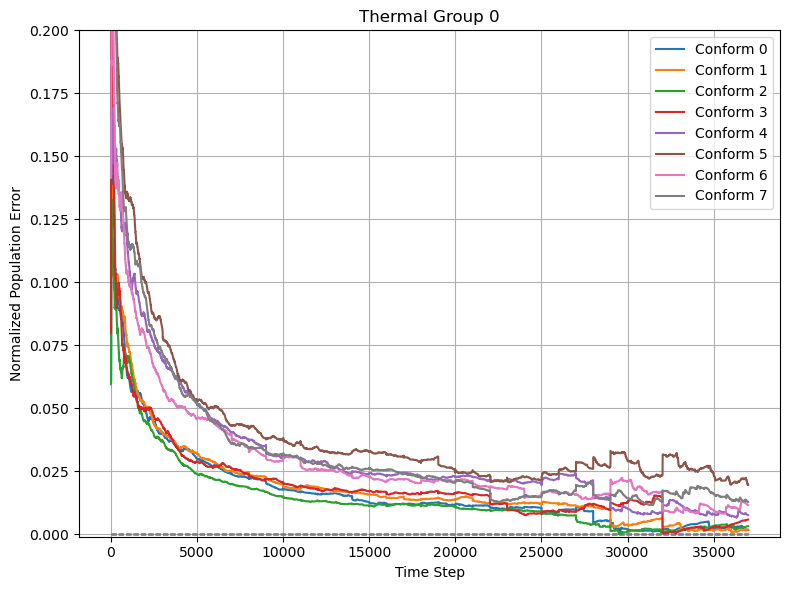

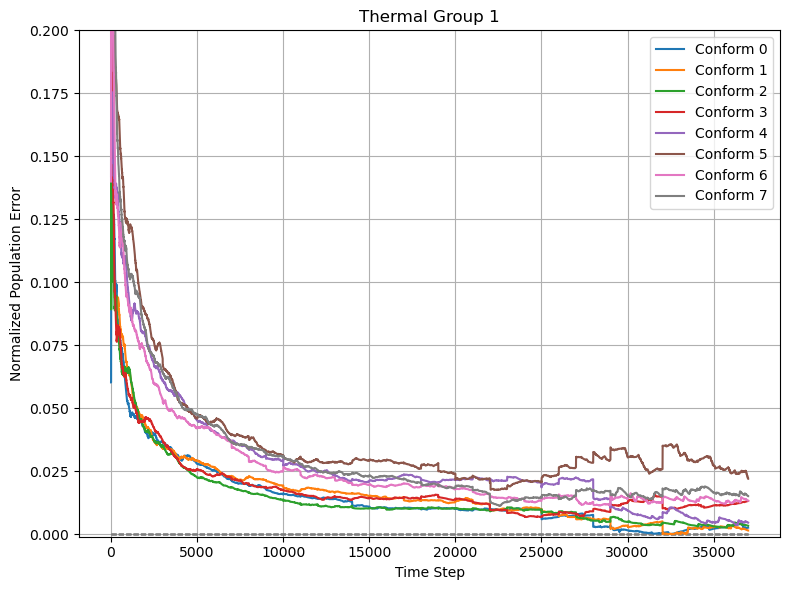

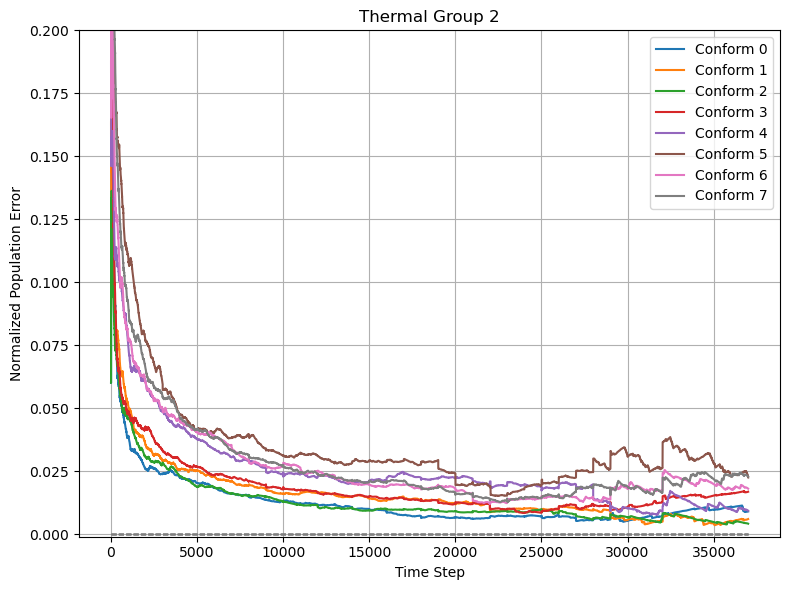

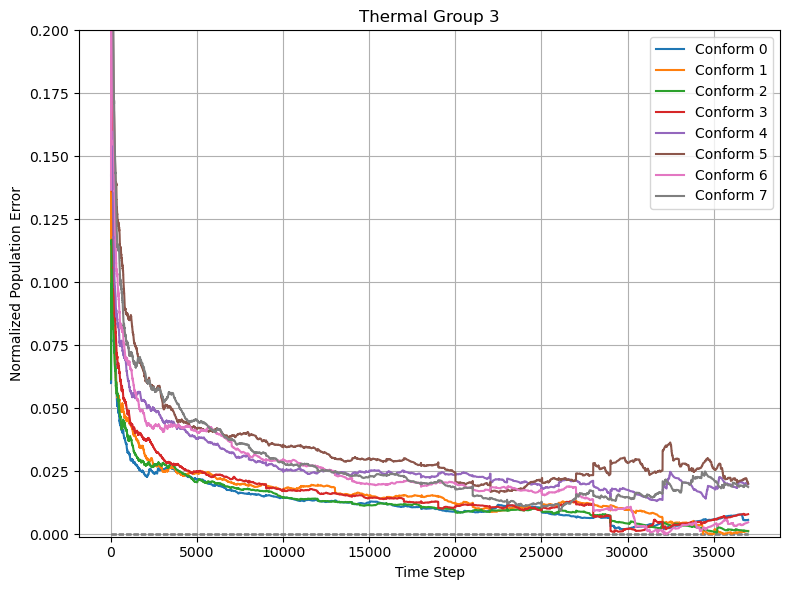

In [48]:
for thermal in range(thermal_num):
    time = np.arange(mean_all_res.shape[2])
    plt.figure(figsize=(8, 6))

    for conform in range(conform_num):
        rmsd = rmsd_all_res[thermal, conform, :]

        # Plot and capture the line object to get the color
        line, = plt.plot(time, rmsd, label=f'Conform {conform}')
        plt.hlines(y=0, xmin=time[0], xmax=time[-1], colors='gray', linestyles='--', linewidth=1)
    
    plt.ylim(-0.001, 0.2)
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Population Error")
    plt.title(f"Thermal Group {thermal}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

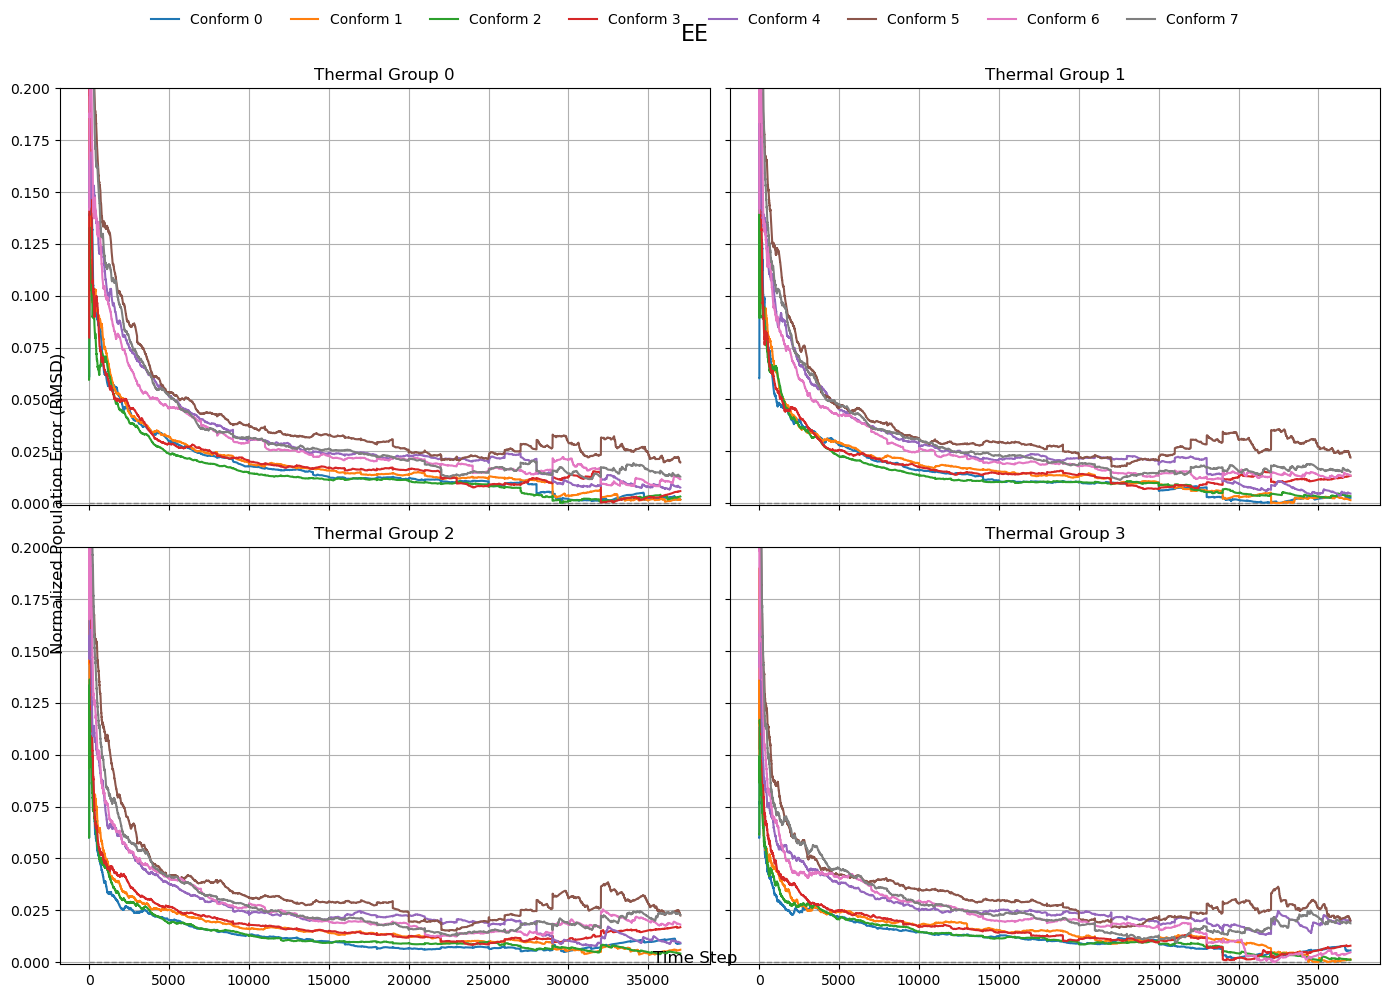

In [51]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
time = np.arange(mean_all_res.shape[2])

for thermal in range(thermal_num):
    row = thermal // 2
    col = thermal % 2
    ax = axs[row, col]

    for conform in range(conform_num):
        rmsd = rmsd_all_res[thermal, conform, :]
        line, = ax.plot(time, rmsd, label=f'Conform {conform}')
    
    ax.hlines(y=0, xmin=time[0], xmax=time[-1], colors='gray', linestyles='--', linewidth=1)
    ax.set_ylim(-0.001, 0.2)
    ax.set_title(f"Thermal Group {thermal}")
    ax.grid(True)

# Global labels
fig.text(0.5, 0.04, "Time Step", ha='center', fontsize=12)
fig.text(0.04, 0.5, "Normalized Population Error (RMSD)", va='center', rotation='vertical', fontsize=12)

# Shared legend from the last axis
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=conform_num, frameon=False)

fig.suptitle("EE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
